In [1]:
import tensorflow

import pandas as pd
import numpy as np
import os
import keras
import random
import cv2
import math
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

from tensorflow.keras.layers import Dense,GlobalAveragePooling2D,Convolution2D,BatchNormalization
from tensorflow.keras.layers import Flatten,MaxPooling2D,Dropout

from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.densenet import preprocess_input

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array

from tensorflow.keras.models import Model

from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip /content/drive/MyDrive/1st_dataset_cotton/cotton_224x224.zip

Archive:  /content/drive/MyDrive/1st_dataset_cotton/cotton_224x224.zip
   creating: cotton_224x224/
   creating: cotton_224x224/bacterial_blight/
  inflating: cotton_224x224/bacterial_blight/2015-angular-leaf-spot-colquitt-county-2.png  
  inflating: cotton_224x224/bacterial_blight/5586201.png  
  inflating: cotton_224x224/bacterial_blight/bact0.png  
  inflating: cotton_224x224/bacterial_blight/bact1.png  
  inflating: cotton_224x224/bacterial_blight/bact10.png  
  inflating: cotton_224x224/bacterial_blight/bact100.png  
  inflating: cotton_224x224/bacterial_blight/bact101.png  
  inflating: cotton_224x224/bacterial_blight/bact102.png  
  inflating: cotton_224x224/bacterial_blight/bact103.png  
  inflating: cotton_224x224/bacterial_blight/bact104.png  
  inflating: cotton_224x224/bacterial_blight/bact105.png  
  inflating: cotton_224x224/bacterial_blight/bact106.png  
  inflating: cotton_224x224/bacterial_blight/bact107.png  
  inflating: cotton_224x224/bacterial_blight/bact108.png  


In [18]:
batch=128
epoch=100
classes=4
directory="/content/cotton_224x224"
save_model_as="densenet_model.h5"

In [19]:
model_d=DenseNet121(weights='imagenet',include_top=False, input_shape=(128, 128, 3))

x=model_d.output

x= GlobalAveragePooling2D()(x)
x= BatchNormalization()(x)
x= Dropout(0.5)(x)
x= Dense(1024,activation='relu')(x)
x= Dense(512,activation='relu')(x)
x= BatchNormalization()(x)
x= Dropout(0.5)(x)

preds=Dense(classes,activation='softmax')(x) #FC-layer

In [20]:
model=Model(inputs=model_d.input,outputs=preds)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 zero_padding2d_2 (ZeroPadd  (None, 134, 134, 3)          0         ['input_2[0][0]']             
 ing2D)                                                                                           
                                                                                                  
 conv1/conv (Conv2D)         (None, 64, 64, 64)           9408      ['zero_padding2d_2[0][0]']    
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 64, 64, 64)           256       ['conv1/conv[0][0]']    

In [21]:
for layer in model.layers[:-8]:
    layer.trainable=False

for layer in model.layers[-8:]:
    layer.trainable=True

In [22]:
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 zero_padding2d_2 (ZeroPadd  (None, 134, 134, 3)          0         ['input_2[0][0]']             
 ing2D)                                                                                           
                                                                                                  
 conv1/conv (Conv2D)         (None, 64, 64, 64)           9408      ['zero_padding2d_2[0][0]']    
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 64, 64, 64)           256       ['conv1/conv[0][0]']    

In [23]:
data=[]
labels=[]
random.seed(42)
imagePaths = sorted(list(os.listdir(directory)))
random.shuffle(imagePaths)
print(imagePaths)

for img in imagePaths:
    path=sorted(list(os.listdir(directory+"/"+img)))
    for i in path:
        image = cv2.imread(directory+"/"+img+'/'+i)
        image = cv2.resize(image, (128,128))
        image = img_to_array(image)
        data.append(image)
        l = label = img
        labels.append(l)

['fussarium_wilt', 'curl_virus', 'healthy', 'bacterial_blight']


In [24]:
data = np.array(data, dtype="float32") / 255.0
labels = np.array(labels)
mlb = LabelBinarizer()
labels = mlb.fit_transform(labels)
print(labels[0])

[0 0 1 0]


In [25]:
(xtrain,xtest,ytrain,ytest)=train_test_split(data,labels,test_size=0.4,random_state=42)
print(xtrain.shape, xtest.shape)

(1024, 128, 128, 3) (684, 128, 128, 3)


In [ ]:
anne = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
checkpoint = ModelCheckpoint(save_model_as, verbose=1, save_best_only=True)

datagen = ImageDataGenerator(zoom_range = 0.2, horizontal_flip=True, shear_range=0.2)


datagen.fit(xtrain)
# Fits-the-model
history = model.fit_generator(datagen.flow(xtrain, ytrain, batch_size=batch),
               steps_per_epoch=xtrain.shape[0] //batch,
               epochs=epoch,
               verbose=2,
               callbacks=[anne, checkpoint],
               validation_data=(xtrain, ytrain))

<ipython-input-37-267e374c158e>:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(datagen.flow(xtrain, ytrain, batch_size=batch),


Epoch 1/100

Epoch 1: val_loss improved from inf to 0.00003, saving model to densenet_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


8/8 - 9s - loss: 0.0099 - accuracy: 0.9971 - val_loss: 2.8544e-05 - val_accuracy: 1.0000 - lr: 0.0010 - 9s/epoch - 1s/step
Epoch 2/100

Epoch 2: val_loss improved from 0.00003 to 0.00002, saving model to densenet_model.h5
8/8 - 6s - loss: 0.0100 - accuracy: 0.9971 - val_loss: 1.7738e-05 - val_accuracy: 1.0000 - lr: 0.0010 - 6s/epoch - 721ms/step
Epoch 3/100

Epoch 3: val_loss improved from 0.00002 to 0.00001, saving model to densenet_model.h5
8/8 - 6s - loss: 0.0093 - accuracy: 0.9980 - val_loss: 1.4356e-05 - val_accuracy: 1.0000 - lr: 0.0010 - 6s/epoch - 728ms/step
Epoch 4/100

Epoch 4: val_loss improved from 0.00001 to 0.00001, saving model to densenet_model.h5
8/8 - 6s - loss: 0.0084 - accuracy: 0.9980 - val_loss: 1.2985e-05 - val_accuracy: 1.0000 - lr: 0.0010 - 6s/epoch - 706ms/step
Epoch 5/100

Epoch 5: val_loss improved from 0.00001 to 0.00001, saving model to densenet_model.h5
8/8 - 7s - loss: 0.0087 - accuracy: 0.9971 - val_loss: 7.6697e-06 - val_accuracy: 1.0000 - lr: 0.0010 -

In [ ]:
ypred = model.predict(xtest)

total = 0
accurate = 0
accurateindex = []
wrongindex = []

for i in range(len(ypred)):
    if np.argmax(ypred[i]) == np.argmax(ytest[i]):
        accurate += 1
        accurateindex.append(i)
    else:
        wrongindex.append(i)

    total += 1

print('Total-test-data;', total, '\taccurately-predicted-data:', accurate, '\t wrongly-predicted-data: ', total - accurate)
print('Accuracy:', round(accurate/total*100, 3), '%')

In [ ]:
#label=['fussarium_wilt', 'curl_virus', 'healthy', 'bacterial_blight']
#label=['Cyst', 'Normal', 'Stone', 'Tumor']
label=['glioma_tumor', 'Normal', 'meningioma_tumor', 'pituitary_tumor']
imidx = random.sample(accurateindex, k=4)

nrows = 2
ncols = 2
fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True,figsize=(15, 12))

n = 0
for row in range(nrows):
    for col in range(ncols):
            ax[row,col].imshow(xtest[imidx[n]])
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(label[np.argmax(ypred[imidx[n]])], label[np.argmax(ytest[imidx[n]])]))
            n += 1

plt.show()

In [ ]:
Ypred = model.predict(xtest)

Ypred = np.argmax(Ypred, axis=1)
Ytrue = np.argmax(ytest, axis=1)

cm = confusion_matrix(Ytrue, Ypred)
plt.figure(figsize=(12, 12))
ax = sns.heatmap(cm, cmap="rocket_r", fmt=".01f",annot_kws={'size':16}, annot=True, square=True, xticklabels=label, yticklabels=label)
ax.set_ylabel('Actual', fontsize=20)
ax.set_xlabel('Predicted', fontsize=20)

In [30]:
from sklearn.metrics import classification_report
import numpy as np

# ...

# Assuming ytest and ypred are your true and predicted labels, respectively
# Make sure they are numpy arrays with the shape (number_of_samples, number_of_classes)
y_true = np.argmax(ytest, axis=1)
y_pred = np.argmax(ypred, axis=1)

# Assuming label is a list or array containing class labels in the correct order
# Example: label = ["class_0", "class_1", ...]
print(classification_report(y_true, y_pred, target_names=label))


                  precision    recall  f1-score   support

    glioma_tumor       1.00      1.00      1.00       178
          Normal       0.99      0.99      0.99       177
meningioma_tumor       0.98      1.00      0.99       169
 pituitary_tumor       1.00      0.99      0.99       160

        accuracy                           0.99       684
       macro avg       0.99      0.99      0.99       684
    weighted avg       0.99      0.99      0.99       684



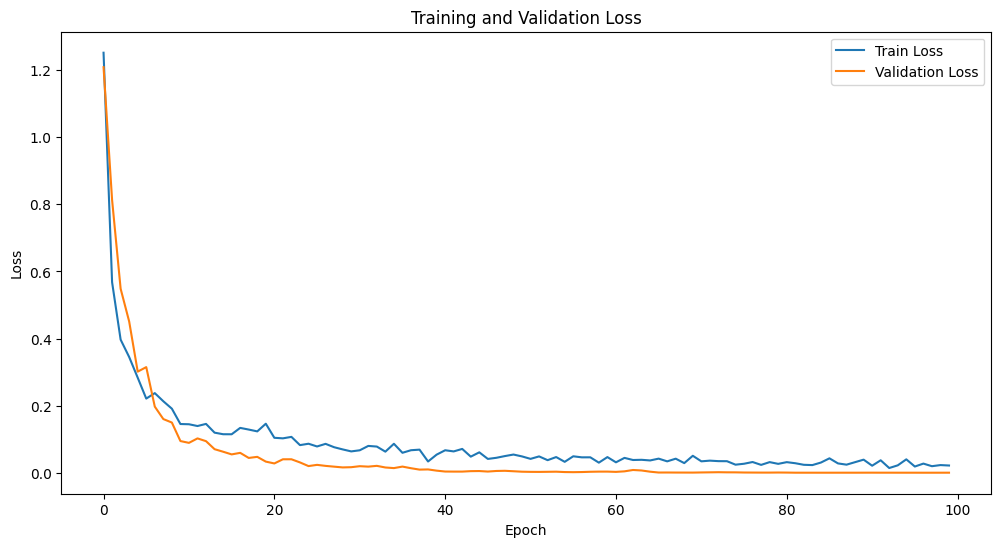

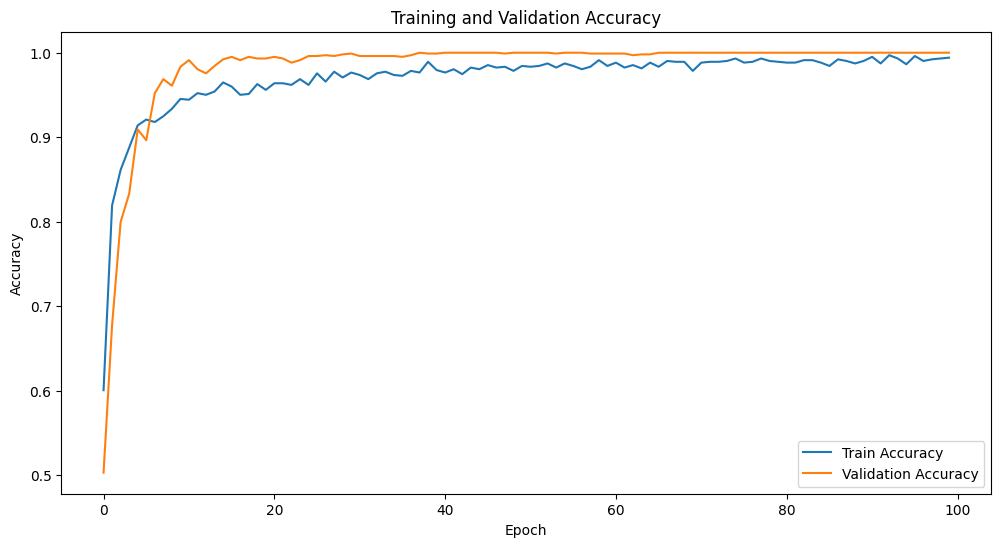

In [31]:
# Assuming you have the correct 'history' object
# Plot the Loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the Accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(classes):
    fpr[i], tpr[i], _ = roc_curve(y_true == i, y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(12, 8))
for i in range(classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (class {i}) (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # diagonal
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed